# Transformer论文精读及复现

## 论文架构
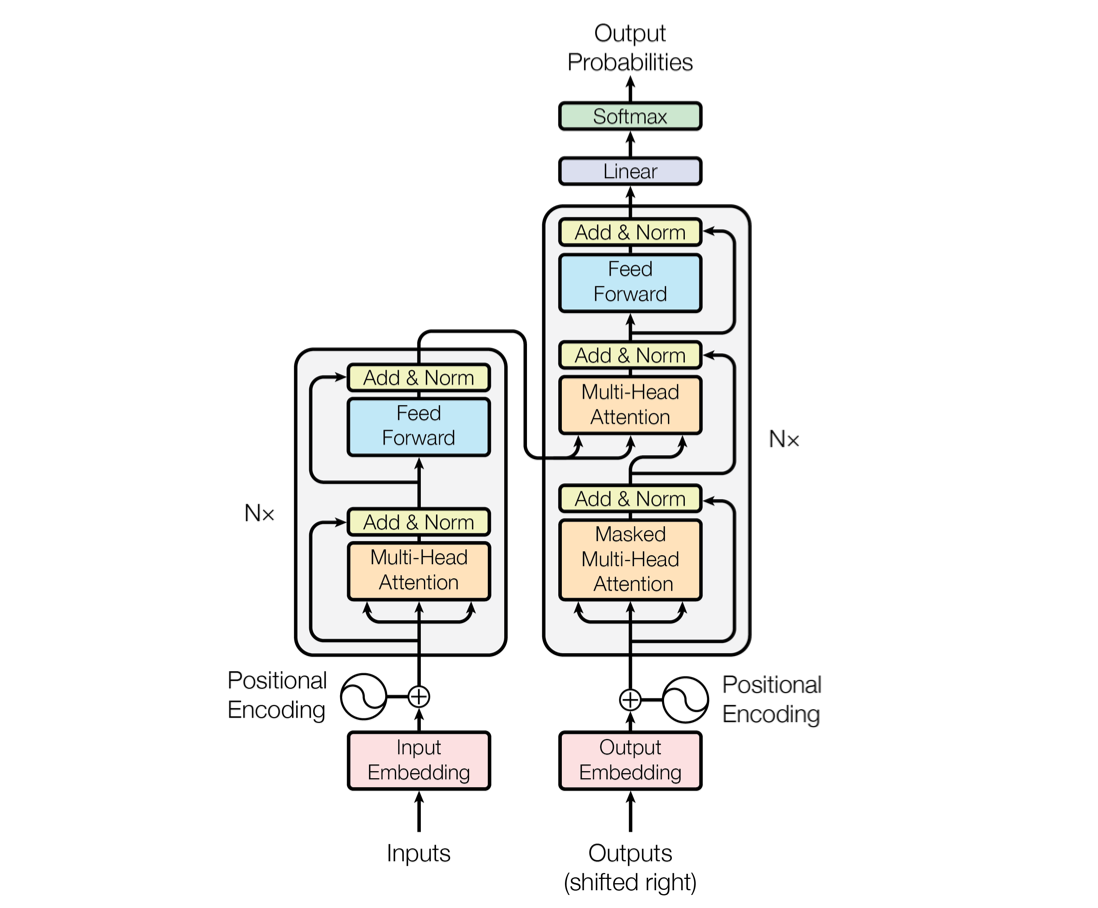

在Transformer诞生之前，Attention和编码器-解码器架构已经得到了广泛应用。Transformer放弃了RNN的递归结构，只是用注意力机制来编码和解码序列信息。

但注意力机制比较难以保存序列的时间信息，因此Transformer采用了位置编码来保存这类信息。

# 缩放点积注意力

论文使用缩放点积注意力机制。给定查询矩阵$Q$、键矩阵K和值矩阵V，注意力输出的数学表达式为：

$$ \operatorname{Attention}(Q, K,V)=\operatorname{Softmax}\left(\frac{Q K^{\top}}{\sqrt{d_{k}}}\right) V $$

- Q：用于查询的向量矩阵
- K：表示键的向量矩阵，用于匹配查询
- V：值矩阵，注意力权重作用于值矩阵
- d_k：建或查询向量的维度。



In [86]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import math

def scaled_dot_product_attention(Q, K, V, mask=None):
    """
    缩放点积注意力计算。
    
    参数:
        Q: 查询矩阵 (batch_size, seq_len_q, embed_size)
        K: 键矩阵 (batch_size, seq_len_k, embed_size)
        V: 值矩阵 (batch_size, seq_len_v, embed_size)
        mask: 掩码矩阵，用于屏蔽不应该关注的位置 (可选)

    返回:
        output: 注意力加权后的输出矩阵
        attention_weights: 注意力权重矩阵
    """

    embed_size = Q.size(-1) # embed_size

    # 计算点积并缩放, 对k的最后两个维度进行转置变成 d*n大小
    # 进行点积计算后，相似度高的两个向量的值会比较大，经过softmax后会得到较大的权重
    scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(embed_size)

    # 处理掩码操作，将mask == 0的位置置为负无穷
    # 掩码操作应用于解码器（自回归模型）的第一个子层，用于防止看到当前预测位置之后的数据
    if mask is not None:
        scores = scores.masked_fill(mask == 0, float('-inf'))
    
    # 对缩放后的分数应用softmax函数得到注意力权重
    attention_weights = f.softmax(scores, dim=-1)

    # 加权求和
    output = torch.matmul(attention_weights, V)

    return output, attention_weights

# 单头注意力

In [87]:
class Attention(nn.Module):
    def __init(self, embed_size):
        """
        单头注意力机制。
        
        参数:
            embed_size: 输入序列（Inputs）的嵌入（Input Embedding）维度，也是论文中所提到的d_model。
        """

        super(Attention, self).__init__()
        self.embed_size = embed_size

        # 定义线性层，用于生成qkv矩阵
        self.w_q = nn.Linear(embed_size, embed_size)
        self.w_k = nn.Linear(embed_size, embed_size)
        self.w_v = nn.Linear(embed_size, embed_size)

        def forward(self, q, k, v, mask=None):
            """
            前向传播函数。
            
            参数:
                q: 查询矩阵 (batch_size, seq_len_q, embed_size)
                k: 键矩阵 (batch_size, seq_len_k, embed_size)
                v: 值矩阵 (batch_size, seq_len_v, embed_size)
                mask: 掩码矩阵，用于屏蔽不应关注的位置 (batch_size, seq_len_q, seq_len_k)

            返回:
                out: 注意力加权后的输出
                attention_weights: 注意力权重矩阵
            """
            # 将输入序列通过线性变换变成Q, K, V
            Q = self.w_q(q)
            K = self.w_k(k)
            V = self.w_v(v)

            out, attention_weights = scaled_dot_product_attention(Q, K, V, mask)

            return out, attention_weights

# 自注意力机制

In [88]:
class SelfAttention(nn.Module):
    def __init(self, embed_size):
        """
        自注意力机制。
        
        参数:
            embed_size: 输入序列（Inputs）的嵌入（Input Embedding）维度，也是论文中所提到的d_model。
        """

        super(SelfAttention, self).__init__()
        self.attention = Attention(embed_size)  # 使用通用的Attention模块


        def forward(self, x, mask=None):
            """
            前向传播函数。
            
            参数:
                x: 输入序列 (batch_size, seq_len_q, embed_size)
                mask: 掩码矩阵，用于屏蔽不应关注的位置 (batch_size, seq_len_q, seq_len_k)

            返回:
                out: 自注意力加权后的输出
                attention_weights: 注意力权重矩阵
            """
            # 自注意力机制中，qkv都来自同一个输入序列
            out, attention_weights = self.attention(x, x, x, mask)

            return out, attention_weights

# 交叉注意力机制

In [89]:
class CrossAttetion(nn.Module):
    def __init(self, embed_size):
        """
        交叉注意力（Cross-Attention）机制。
        
        参数:
            embed_size: 输入序列的嵌入维度。
        """

        super(CrossAttetion, self).__init__()
        self.attention = Attention(embed_size)

    def forward(self, q, kv, mask=None):
        """
        前向传播函数。
        
        参数:
            query: 查询矩阵的输入 (batch_size, seq_len_q, embed_size)
            kv: 键和值矩阵的输入 (batch_size, seq_len_kv, embed_size)
            mask: 掩码矩阵 (batch_size, seq_len_q, seq_len_kv)

        返回:
            out: 注意力加权后的输出 (batch_size, seq_len_q, embed_size)
            attention_weights: 注意力权重矩阵 (batch_size, seq_len_kv, seq_len_kv)
        """
        # 交叉注意力机制中，q和kv不同，q来自解码器， kv来自编码器
        out, attention_weights = self.attention(q, kv, kv, mask)

        return out, attention_weights

# 多头注意力机制(易理解版)


In [90]:
# class MultiHeadAttention(nn.Module):
#     def __init__(self, embed_size, num_heads):
#         """
#         多头注意力机制。

#         参数：
#             embed_size：输入序列的嵌入维度。
#             num_heads：注意力头的数量。
#         """

#         super(MultiHeadAttention, self).__init__()
#         self.embed_size = embed_size
#         self.num_heads = num_heads

#         #为每一个头单独定义Q,K,V的线性层，输出维度为embed_size
#         self.w_q = nn.ModuleList([nn.Linear(embed_size, embed_size) for _ in range(num_heads)])
#         self.w_k = nn.ModuleList([nn.Linear(embed_size, embed_size) for _ in range(num_heads)])
#         self.w_v = nn.ModuleList([nn.Linear(embed_size, embed_size) for _ in range(num_heads)])

#         #最后将多头注意力输出的序列拼接到最后一个维度，相当于增加序列的长度，最后使用输出全连接层还原为初始维度
#         self.fc_out = nn.Linear(num_heads * embed_size, embed_size)

#     def forward(self, q, k, v, mask=None):
#         """
#         前向传播函数。

#         参数:
#             q: 查询矩阵(batch_size, seq_len_q, embed_size)
#             k: 键矩阵(batch_size, seq_len_k, embed_size)
#             v: 值矩阵(batch_size, seq_len_v, embed_size)
#             mask: 掩码矩阵(batch_size, seq_len_q, seq_len_k)
        
#         返回:
#             out: 注意力加权后的输出
#             attention_weights: 注意力权重矩阵
#         """
        
#         batch_size = q.shape[0]
#         multi_head_outputs = []

#         for i in range(self.num_heads):
#             Q = self.w_q[i](q)
#             K = self.w_k[i](k)
#             V = self.w_v[i](v)

#             scaled_attention = scaled_dot_product_attention(Q, K, V, mask)
#             multi_head_outputs.append(scaled_attention)
        
#         #将输出连接到最后一维度
#         concat_out = torch.cat(multi_head_outputs, dim=-1) #(batch_size, seq_len_q, embed_size * num_heads)

#         #输出线性层
#         out = self.fc_out(concat_out) #(batch_size, seq_len_q, embed_size)

#         return out



# 多头注意力机制（论文对应版）和缩放点积注意力（论文对应版）

In [91]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math



class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, h):
        """
        多头注意力机制。

        参数：
            d_model: embed_size
            h: num_heads
        """

        super(MultiHeadAttention, self).__init__()
        assert d_model % h == 0, "def_model必须能被h整除。"

        self.d_model = d_model
        self.h = h

        #共享的Q, K, V 线性层
        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)

        #输出层，将多头拼接后映射回d_model
        self.fc_out = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask=None):
        """
        前向传播函数。
        
        参数:
            q: 查询矩阵 (batch_size, seq_len_q, d_model)
            k: 键矩阵 (batch_size, seq_len_k, d_model)
            v: 值矩阵 (batch_size, seq_len_v, d_model)
            mask: 掩码矩阵 (batch_size, 1, seq_len_q, seq_len_k)

        返回:
            out: 注意力加权后的输出
            attention_weights: 注意力权重矩阵
        """

        batch_size =q.size(0)

        #获取查询和键值的序列长度
        seq_len_q = q.size(1)
        seq_len_k = k.size(1)

        #将线性变换后的共享矩阵拆分变为多头，交换第1和第2维的原因详见点积注意力的计算是对seq_len和dim这两维进行运算
        #调整维度为 (batch_size, h, seq_len, d_k)
        #d_k 就是每个注意力头的维度
        Q = self.w_q(q).view(batch_size, seq_len_q, self.h, -1).transpose(1, 2)
        K = self.w_k(k).view(batch_size, seq_len_k, self.h, -1).transpose(1, 2)
        V = self.w_v(v).view(batch_size, seq_len_k, self.h, -1).transpose(1, 2)

        #计算缩放点积注意力
        scaled_attention, _= scaled_dot_product_attention(Q, K, V, mask)

        concat_out = scaled_attention.transpose(1,2).contiguous().view(batch_size, -1, self.d_model)

        #通过输出线性层
        out  = self.fc_out(concat_out) #(batch_size, seq_len_q, )

        return out



def scaled_dot_product_attention(Q, K, V, mask=None):
    """
    缩放点积注意力计算。
    
    参数:
        Q: 查询矩阵 (batch_size, seq_len_q, d_k)
        K: 键矩阵 (batch_size, seq_len_k, d_k)
        V: 值矩阵 (batch_size, seq_len_v, d_k)
        mask: 掩码矩阵(batch_size, 1, seq_len_q, seq_len_k) 或 (1, 1, seq_len_q, seq_len_k) 或 (batch_size, h, seq_len_q, seq_len_k)

    返回:
        output: 注意力加权后的输出矩阵
        attention_weights: 注意力权重矩阵
    """

    d_k = Q.size(-1) # d_k

    # 计算点积并缩放, 对k的最后两个维度进行转置变成 d*n大小
    # 进行点积计算后，相似度高的两个向量的值会比较大，经过softmax后会得到较大的权重
    scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)

    # 处理掩码操作，将mask == 0的位置置为负无穷
    # 掩码操作应用于解码器（自回归模型）的第一个子层，用于防止看到当前预测位置之后的数据
    if mask is not None:
        scores = scores.masked_fill(mask == 0, float('-inf'))
    
    # 对缩放后的分数应用softmax函数得到注意力权重
    attention_weights = f.softmax(scores, dim=-1)

    # 加权求和
    output = torch.matmul(attention_weights, V)

    return output, attention_weights

# Position-wise Feed-Forward Networks（FFN）
本质上就是一个mlp

In [92]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dorpout=0.1):
        """
        位置前馈网络。

        参数：
            d_model: 输入向量和输出向量维度
            d_ff: 隐藏层的维度
            dropout: 随机失活率


        """

        super(PositionWiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)


    def forward(self, x):
        return self.w_2(self.w_1(x).relu())

# 残差链接

In [93]:
class ResidualConnection(nn.Module):
    def __init__(self, dropout=0.1):
        """
        残差连接，用于在每个子层后添加残差连接和 Dropout。
        
        参数:
            dropout: Dropout 概率，用于在残差连接前应用于子层输出，防止过拟合。
        """

        super(ResidualConnection, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
    
    def forward(self, x, sublayer):
        """
        前向传播函数。
        
        参数:
            x: 残差连接的输入张量，形状为 (batch_size, seq_len, d_model)。
            sublayer: 子层模块的函数，多头注意力或前馈网络。

        返回:
            经过残差连接和 Dropout 处理后的张量，形状为 (batch_size, seq_len, d_model)。
        """

        #将子层的输出应用dropout然后与输入相加
        return x + self.dropout(sublayer(x))

# 层归一化LayerNorm

In [94]:
class LayerNorm(nn.Module):
    def __init__(self, feature_size, eposilon=1e-9):
        """
        层归一化，用于对最后一个维度进行归一化。
        
        参数:
            feature_size: 输入特征的维度大小，即归一化的特征维度。
            epsilon: 防止除零的小常数。
        """

        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(feature_size)) #可学习的缩放参数，初始化为1
        self.beta = nn.Parameter(torch.zeros(feature_size)) #可学习的偏移参数，初始化为0
        self.eposilon = eposilon    #防止标准差很小时出现除0操作


    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        
        #layernorm最后一步和线性层比较相似，但layernorm的操作为缩放元素，线性层是线性组合
        return self.gamma * (x - mean) / (std + self.eposilon) + self.beta

# Add & Norm

In [95]:
class SublayerConnection(nn.Module):
    def __init__(self, feature_size, dropout=0.1, eposilon=1e-9):
        """
        子层连接，包括残差连接和层归一化，应用于 Transformer 的每个子层。

        参数:
            feature_size: 输入特征的维度大小，即归一化的特征维度。
            dropout: 残差连接中的 Dropout 概率。
            epsilon: 防止除零的小常数。
        """
        super(SublayerConnection, self).__init__()
        self.residual = ResidualConnection(dropout)
        self.norm = LayerNorm(feature_size, eposilon)

    
    def forward(self, x, sublayer):
        #将子层输出应用dropout后进行残差连接，最后归一化
        return self.norm(self.residual(x,sublayer))


# 嵌入层Embeddings

In [96]:
class Embeddings(nn.Module):
    def __init__(self, vocab_size, d_model):
        """
        嵌入，将 token ID 转换为固定维度的嵌入向量，并进行缩放。

        参数:
            vocab_size: 词汇表大小。
            d_model: 嵌入向量的维度。
        """
        super(Embeddings, self).__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
        self.scale_factor = math.sqrt(d_model)

    def forward(self, x):
        """
        前向传播函数。

        参数:
            x: 输入张量，形状为 (batch_size, seq_len)，其中每个元素是 token ID。

        返回:
            缩放后的嵌入向量，形状为 (batch_size, seq_len, d_model)。
        """
        return self.embed(x) * self.scale_factor

# 位置编码

In [97]:
class PositionEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        """
        位置编码，为输入序列中的每个位置添加唯一的位置表示，以引入位置信息。

        参数:
            d_model: 嵌入维度，即每个位置的编码向量的维度。
            dropout: 位置编码后应用的 Dropout 概率。
            max_len: 位置编码的最大长度，适应不同长度的输入序列。
        """

        super(PositionEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        #创建位置编码矩阵,生成一个从0到最大序列长度的序列，并在维度1上增加一个维度用于存放位置编码
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)

        #计算每个维度对应的概率
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)
        )

        pe[:,0::2] = torch.sin(position * div_term)     #偶数维度
        pe[:,1::2] = torch.cos(position * div_term)     #奇数维度


        #增加一个维度，方便后续与输入相加,形状变为 (1, max_len, d_model)
        pe = pe.unsqueeze(0)

        # 将位置编码注册为模型的缓冲区，不作为参数更新
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        前向传播函数。

        参数:
            x: 输入序列的嵌入向量，形状为 (batch_size, seq_len, d_model)。

        返回:
            加入位置编码和 Dropout 后的嵌入向量，形状为 (batch_size, seq_len, d_model)。
        """

        # 取出与输入序列相同长度的位置编码与输入相加
        x = x + self.pe[:, :x.size(1), :]

        return self.dropout(x)


# 编码器输入处理

In [98]:
class SourceEmbedding(nn.Module):
    def __init__(self, src_vocab_size, d_model, dropout=0.1):
        """
        源序列嵌入，将输入的 token 序列转换为嵌入向量并添加位置编码。

        参数:
            src_vocab_size: 源语言词汇表的大小
            d_model: 嵌入向量的维度
            dropout: 在位置编码后应用的 Dropout 概率
        """
        super(SourceEmbedding, self).__init__()
        self.embed = Embeddings(src_vocab_size, d_model)
        self.positional_encoding = PositionEncoding(d_model, dropout)

    def forward(self, x):
        """
        前向传播函数。

        参数:
            x: 源语言序列的输入张量，形状为 (batch_size, seq_len_src)，其中每个元素是 token ID。

        返回:
            添加位置编码后的嵌入向量，形状为 (batch_size, seq_len_src, d_model)。
        """

        x = self.embed(x)
        return self.positional_encoding(x)

# 解码器输入处理

In [99]:
class TargetEmbedding(nn.Module):
    def __init__(self, tgt_vocab_size, d_model, dropout=0.1):
        """
        目标序列嵌入，将目标序列的 token ID 转换为嵌入向量并添加位置编码。

        参数:
            tgt_vocab_size: 目标语言词汇表的大小
            d_model: 嵌入向量的维度
            dropout: 在位置编码后应用的 Dropout 概率
        """
        super(TargetEmbedding, self).__init__()
        self.embed = Embeddings(tgt_vocab_size, d_model)
        self.positional_encoding = PositionEncoding(d_model, dropout)

    def forward(self, x):
        """
        前向传播函数。

        参数:
            x: 目标序列的输入张量，形状为 (batch_size, seq_len_tgt)，其中每个元素是 token ID。

        返回:
            添加位置编码后的嵌入向量，形状为 (batch_size, seq_len_tgt, d_model)。
        """

        x = self.embed(x)
        return self.positional_encoding(x)

# 掩码


In [100]:
#填充掩码
def create_padding_mask(seq, pad_token_id=0):
    # seq 的形状为 (batch_size, seq_len)
    #（扩展维度是为了后续与 look_ahead_mask 广播计算）
    mask = (seq != pad_token_id).unsqueeze(1).unsqueeze(2)  # (batch_size, 1, 1, seq_len)
    return mask  # 在注意力计算时，填充值为 0 的位置会被屏蔽


#未来信息掩码
def create_look_ahead_mask(size):
    mask = torch.tril(torch.ones(size, size)).type(torch.bool)  # 下三角矩阵
    return mask  # (seq_len, seq_len)


#组合实现
def create_decoder_mask(tgt_seq, pad_token_id=0):
    padding_mask = create_padding_mask(tgt_seq, pad_token_id)  # (batch_size, 1, 1, seq_len_tgt)
    look_ahead_mask = create_look_ahead_mask(tgt_seq.size(1)).to(tgt_seq.device)  # (seq_len_tgt, seq_len_tgt)

    combined_mask = look_ahead_mask.unsqueeze(0) & padding_mask  # (batch_size, 1, seq_len_tgt, seq_len_tgt)
    return combined_mask

# 编码器层

In [101]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, h, d_ff, dropout):
        """
        编码器层。
        
        参数:
            d_model: 嵌入维度
            h: 多头注意力的头数
            d_ff: 前馈神经网络的隐藏层维度
            dropout: Dropout 概率
        """

        super(EncoderLayer, self).__init__()
        self.self_atten = MultiHeadAttention(d_model, h)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff, dropout)
        
        #定义两个子层连接，分别用于多头注意力和前馈神经网络
        self.sublayers = nn.ModuleList([SublayerConnection(d_model,dropout) for _ in range(2)])
        self.d_model = d_model

    def forward(self, x, src_mask):
        """
        前向传播函数。

        参数:
            x: 输入张量，形状为 (batch_size, seq_len, d_model)。
            src_mask: 源序列掩码，用于自注意力。

        返回:
            编码器层的输出，形状为 (batch_size, seq_len, d_model)。
        """

        x = self.sublayers[0](x, lambda x: self.self_atten(x, x, x, src_mask))  #自注意力子层
        x = self.sublayers[1](x, self.feed_forward)

        return x

# 解码器层

In [102]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, h, d_ff, dropout):
        """
        解码器层。
        
        参数:
            d_model: 嵌入维度
            h: 多头注意力的头数
            d_ff: 前馈神经网络的隐藏层维度
            dropout: Dropout 概率
        """

        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, h)
        self.cross_attn = MultiHeadAttention(d_model, h)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff, dropout)

        #定义三个子连接层
        self.sublayers = nn.ModuleList([SublayerConnection(d_model,dropout) for _ in range(3)])
        self.d_model = d_model

    def forward(self, x, menmory, src_mask, tgt_mask):
        """
        前向传播函数。
        参数:
            x: 解码器输入 (batch_size, seq_len_tgt, d_model)
            memory: 编码器输出 (batch_size, seq_len_src, d_model)
            src_mask: 源序列掩码，用于交叉注意力
            tgt_mask: 目标序列掩码，用于自注意力
        返回:
            x: 解码器层的输出
        """

        #第一个子层
        x = self.sublayers[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))

        #第二个子层：交叉多头注意力
        x = self.sublayers[1](x, lambda x: self.cross_attn(x, menmory, menmory, src_mask))

        #第三个子层：前馈神经网络
        x = self.sublayers[2](x, self.feed_forward)

        return x


# 编码器

In [103]:
class Encoder(nn.Module):
    def __init__(self, d_model, N, h, d_ff, dropout=0.1):
        """
        编码器，由 N 个 EncoderLayer 堆叠而成。
        
        参数:
            d_model: 嵌入维度
            N: 编码器层的数量
            h: 多头注意力的头数
            d_ff: 前馈神经网络的隐藏层维度
            dropout: Dropout 概率
        """

        super(Encoder, self).__init__()
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, h, d_ff, dropout) for _ in range(N)
        ])
        self.norm = LayerNorm(d_model)  #最后层归一化

    def forward(self, x, mask):
        """
        前向传播函数。
        
        参数:
            x: 输入张量 (batch_size, seq_len, d_model)
            mask: 输入掩码
        
        返回:
            编码器的输出
        """
        for layer in self.layers:
            x = layer(x, mask)

        return self.norm(x)

        

# 解码器

In [104]:
class Decoder(nn.Module):
    def __init__(self, d_model, N, h, d_ff, dropout=0.1):
        """
        解码器，由 N 个 DecoderLayer 堆叠而成。
        
        参数:
            d_model: 嵌入维度
            N: 解码器层的数量
            h: 多头注意力的头数
            d_ff: 前馈神经网络的隐藏层维度
            dropout: Dropout 概率
        """
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList([
            DecoderLayer(d_model, h, d_ff, dropout) for _ in range(N)
        ])

        self.norm = LayerNorm(d_model)

    def forward(self, x, menmory, src_mask, tgt_mask):
        """
        前向传播函数。
        
        参数:
            x: 解码器输入 (batch_size, seq_len_tgt, d_model)
            memory: 编码器的输出 (batch_size, seq_len_src, d_model)
            src_mask: 用于交叉注意力的源序列掩码
            tgt_mask: 用于自注意力的目标序列掩码
            
        返回:
            解码器的输出
        """
        for layer in self.layers:
            x = layer(x, menmory, src_mask, tgt_mask)
        return self.norm(x)

# 完整模型

In [105]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, N, h, d_ff, dropout=0.1):
        """
        Transformer 模型，由编码器和解码器组成。

        参数:
            src_vocab_size: 源语言词汇表大小
            tgt_vocab_size: 目标语言词汇表大小
            d_model: 嵌入维度
            N: 编码器和解码器的层数
            h: 多头注意力的头数
            d_ff: 前馈神经网络的隐藏层维度
            dropout: Dropout 概率
        """
        super(Transformer, self).__init__()

        #输入嵌入和位置编码
        self.src_embedding = SourceEmbedding(src_vocab_size, d_model, dropout)
        self.tgt_embedding = SourceEmbedding(tgt_vocab_size, d_model, dropout)

        #编码器和解码器
        self.encoder = Encoder(d_model, N, h, d_ff, dropout)
        self.decoder = Decoder(d_model, N, h, d_ff, dropout)

        #输出线性层
        self.fc_out = nn.Linear(d_model, tgt_vocab_size)

    def forward(self, src, tgt):
        """
        前向传播函数。

        参数:
            src: 源序列输入 (batch_size, seq_len_src)
            tgt: 目标序列输入 (batch_size, seq_len_tgt)

        返回:
            Transformer 的输出（未经过 Softmax）
        """

        #生成掩码
        src_mask = create_padding_mask(src)
        tgt_mask = create_decoder_mask(tgt)

        #编码器
        encoder_output = self.encoder(self.src_embedding(src), src_mask)

        #解码器
        decoder_output = self.decoder(self.tgt_embedding(tgt), encoder_output, src_mask, tgt_mask)

        #输出层
        output = self.fc_out(decoder_output)

        return output

In [106]:
# 定义词汇表大小（根据数据集）
src_vocab_size = 5000  # 源语言词汇表大小
tgt_vocab_size = 5000  # 目标语言词汇表大小

# 使用 Transformer base 参数
d_model = 512      # 嵌入维度
N = 6              # 编码器和解码器的层数
h = 8              # 多头注意力的头数
d_ff = 2048        # 前馈神经网络的隐藏层维度
dropout = 0.1      # Dropout 概率

# 实例化模型
model = Transformer(
    src_vocab_size=src_vocab_size,
    tgt_vocab_size=tgt_vocab_size,
    d_model=d_model,
    N=N,
    h=h,
    d_ff=d_ff,
    dropout=dropout
)

# 打印模型架构
print(model)

Transformer(
  (src_embedding): SourceEmbedding(
    (embed): Embeddings(
      (embed): Embedding(5000, 512)
    )
    (positional_encoding): PositionEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (tgt_embedding): SourceEmbedding(
    (embed): Embeddings(
      (embed): Embedding(5000, 512)
    )
    (positional_encoding): PositionEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (encoder): Encoder(
    (layers): ModuleList(
      (0-5): 6 x EncoderLayer(
        (self_atten): MultiHeadAttention(
          (w_q): Linear(in_features=512, out_features=512, bias=True)
          (w_k): Linear(in_features=512, out_features=512, bias=True)
          (w_v): Linear(in_features=512, out_features=512, bias=True)
          (fc_out): Linear(in_features=512, out_features=512, bias=True)
        )
        (feed_forward): PositionWiseFeedForward(
          (w_1): Linear(in_features=512, out_features=2048, bias=True)
          (w_2): Linear(in_features=2048, o

# 示例

In [107]:
import torch
import torch.nn

batch_size = 32
seq_len_src = 10
seq_len_tgt = 15

In [108]:
#构造输入
src = torch.randint(0, 100, (batch_size, seq_len_src))
tgt = torch.randint(0, 100, (batch_size, seq_len_tgt))

print(src)
print(tgt)

tensor([[38, 86, 43, 31, 48, 41, 17, 16, 68, 87],
        [70, 47, 50, 23, 63, 58, 88, 48,  2, 79],
        [87, 94, 48, 84, 48,  0, 96, 61,  7, 46],
        [77,  5, 51,  5, 25, 76, 56, 75, 92, 32],
        [78, 65,  3, 88, 45, 87, 98, 43, 65, 87],
        [68, 72, 15, 75, 89, 39, 65, 71, 17, 54],
        [95, 67, 37, 31, 30, 21, 47, 78, 32, 36],
        [48, 77, 25, 70, 38, 99, 28, 27, 54, 84],
        [33, 28, 19, 36, 59, 65, 71, 91, 17, 64],
        [50, 17, 71, 83, 87, 85, 88, 16, 12, 10],
        [84, 43, 39, 13, 13, 95, 96, 64, 94, 90],
        [87, 65, 93, 21, 22, 88, 68, 35, 32, 94],
        [15,  9,  5, 99, 90,  6, 26, 66, 62, 94],
        [39, 25, 38, 94, 54,  4, 67, 16, 24, 21],
        [48, 83, 58, 29, 23, 21, 84, 59, 99, 77],
        [95, 96, 59, 12, 24, 48, 69, 46, 93, 79],
        [64,  8, 16, 33, 37,  6, 52, 98, 21, 31],
        [24,  7, 55, 88,  6, 22, 52, 33,  6, 75],
        [40, 42, 36, 33, 82, 23, 25, 32, 82, 89],
        [ 5, 69, 30, 44, 38, 83, 38, 16, 16, 82],


In [109]:
#获得掩码
src_mask = create_padding_mask(src)
tgt_mask = create_decoder_mask(tgt)

print(src_mask,tgt_mask)

tensor([[[[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True]]],


        [[[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True]]],


        [[[ True,  True,  True,  True,  True, False,  True,  True,  True,  True]]],


        [[[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True]]],


        [[[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True]]],


        [[[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True]]],


        [[[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True]]],


        [[[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True]]],


        [[[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True]]],


        [[[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True]]],


        [[[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True]]],


        [[[ True,  True,  True,  True,  True,  True,  

In [110]:
#模型输出
output = model(src, tgt)

# 打印各部分的输出形状
print("Source embedding shape:", model.src_embedding(src).shape)  # (batch_size, seq_len_src, d_model)
print("Encoder output shape:", model.encoder(model.src_embedding(src), src_mask).shape)  # (batch_size, seq_len_src, d_model)
print("Target embedding shape:", model.tgt_embedding(tgt).shape)  # (batch_size, seq_len_tgt, d_model)
print("Decoder output shape:", model.decoder(model.tgt_embedding(tgt), model.encoder(model.src_embedding(src), src_mask), src_mask, tgt_mask).shape)  # (batch_size, seq_len_tgt, d_model)
print("Final output shape:", output.shape)  # (batch_size, seq_len_tgt, tgt_vocab_size)

Source embedding shape: torch.Size([32, 10, 512])
Encoder output shape: torch.Size([32, 10, 512])
Target embedding shape: torch.Size([32, 15, 512])
Decoder output shape: torch.Size([32, 15, 512])
Final output shape: torch.Size([32, 15, 5000])


In [111]:
#PyTorch官方实现

d_model = 512
N = 6
h = 8
d_ff = 2048
dropout = 0.1

model_pytorch = nn.Transformer(
    d_model=d_model,
    nhead=h,
    num_encoder_layers=N,
    num_decoder_layers=N,
    dim_feedforward=d_ff,
    dropout=dropout,
    batch_first=True
)
print(model_pytorch)

Transformer(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, o